# Preprocessing generale

Prima di tutto scegliamo di diminuire le modalità di gioco eliminando quelle che contengono pochi record (<10k) in questo modo otteniamo le combinazioni di prima o terza persona X solo, duo, sq4.

Siccome è possibili giocare anche in sq3 andiamo a creare una nuova colonna con il numero effettivo di giocatori nella squadra (cri: alcune sq risultano da 5 persone????)

Andiamo poi a trasformare il tipo di match in 2 colonne: #giocatoriMatch e isFirstPerson


L'idea è quella di esplorare più strade:
- Clustering: Il cluster diretto con i dati potrebbe andare ad individuare solo le modalità del match. 
  - Accorpiamo i dati e facciamo un clustering a livello di gruppi
  - Proviamo a fare un clustering per ogni tipo di gruppo
- Classificazione
  - Classificatore base: ci individua già la divisione per match type? (decision tree, importanza feature)
  - Classificatore con dati accorpati
  - Classificatori diversi per ogni tipo di match

## Divisione del tipo di match

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as pltù
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark import SparkContext
from pyspark.sql.functions import *
#from pyspark.sql import SQLContext


# initialize a new Spark Context to use for the execution of the script
sc = SparkContext(appName="MY-APP-NAME", master="local[*]")
#sqlCtx = SQLContext(sc)
# prevent useless logging messages
sc.setLogLevel("ERROR")

from pyspark.sql import SparkSession
import pandas as pd

spark = SparkSession.builder \
    .master("local") \
    .appName("AppName") \
    .getOrCreate()


# load the dataset
data = spark.read.csv("data.csv", header=True, sep=',',inferSchema="true")
data = data.withColumn("distance", data['swimDistance'] + data['walkDistance'] + data['rideDistance'])
data.dtypes

[('Id', 'string'),
 ('groupId', 'string'),
 ('matchId', 'string'),
 ('assists', 'int'),
 ('boosts', 'int'),
 ('damageDealt', 'double'),
 ('DBNOs', 'int'),
 ('headshotKills', 'int'),
 ('heals', 'int'),
 ('killPlace', 'int'),
 ('killPoints', 'int'),
 ('kills', 'int'),
 ('killStreaks', 'int'),
 ('longestKill', 'double'),
 ('matchDuration', 'int'),
 ('matchType', 'string'),
 ('maxPlace', 'int'),
 ('numGroups', 'int'),
 ('rankPoints', 'int'),
 ('revives', 'int'),
 ('rideDistance', 'double'),
 ('roadKills', 'int'),
 ('swimDistance', 'double'),
 ('teamKills', 'int'),
 ('vehicleDestroys', 'int'),
 ('walkDistance', 'double'),
 ('weaponsAcquired', 'int'),
 ('winPoints', 'int'),
 ('winPlacePerc', 'double'),
 ('distance', 'double')]

In [2]:
from pyspark.sql import SQLContext

sqlCtx = SQLContext(sc)

data.createOrReplaceTempView("pubg")
data.createOrReplaceTempView("pubg_original")

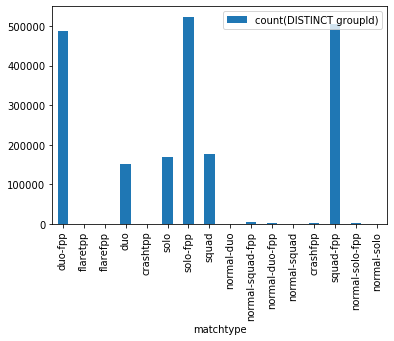

In [3]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) FROM pubg GROUP BY matchtype""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [4]:
toKeep = tmp.rdd.filter(lambda x: x[1] > 10000).map(lambda x: x["matchtype"]).collect()

In [17]:
data = data.filter(data.matchType.isin(toKeep))
data.createOrReplaceTempView("pubg")

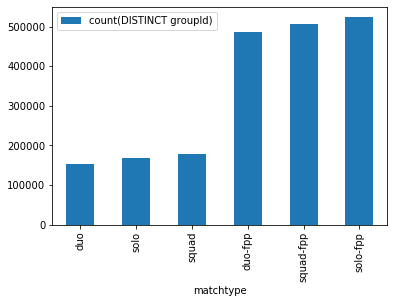

In [18]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [19]:
data = data.withColumn("isFirstPerson", when(col("matchtype").contains("fpp"), True).otherwise(False))

In [20]:
data = data.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

data.createOrReplaceTempView("pubg")

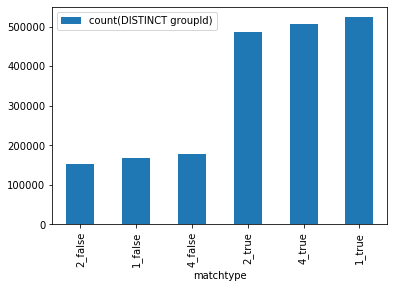

In [9]:
tmp = sqlCtx.sql("""SELECT CONCAT(matchtype, '_', isFirstPerson) as matchtype, count(distinct groupId) 
                        FROM pubg GROUP BY CONCAT(matchtype, '_', isFirstPerson)
                        ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

## Discretizzazione della target variable

In [10]:
#data = data.withColumn("winPlacePerc", when(col("winPlacePerc") == 0 , 2)
#                           .when(col("matchtype").contains("solo"), 1)
#                           .otherwise(4))
#
data.createOrReplaceTempView("pubg")

In [11]:
lista = data.where(data.numGroups == 26).rdd.map(lambda x: x["winPlacePerc"]).collect()

In [12]:
tmp = sqlCtx.sql("""SELECT winPlacePerc FROM pubg where numGroups = 25""")

In [13]:
lista

[0.4444,
 0.7308,
 0.1923,
 0.52,
 0.2222,
 0.64,
 0.72,
 0.4231,
 0.3462,
 0.6538,
 0.8889,
 0.0769,
 0.5385,
 0.9259,
 0.0741,
 0.5385,
 0.08,
 0.1071,
 0.92,
 0.0,
 0.6923,
 0.1852,
 0.4444,
 0.3462,
 0.6154,
 0.44,
 0.8148,
 0.48,
 0.037,
 0.1786,
 0.1852,
 0.16,
 0.12,
 0.8462,
 0.0741,
 0.3704,
 0.0385,
 0.6923,
 0.0,
 0.76,
 0.16,
 0.1154,
 0.7692,
 0.3462,
 0.2963,
 1.0,
 0.9259,
 0.1154,
 0.12,
 0.3077,
 1.0,
 0.8077,
 0.28,
 0.36,
 0.9259,
 0.7143,
 0.7778,
 0.4643,
 0.44,
 0.9231,
 0.3077,
 0.0,
 0.84,
 0.32,
 0.3462,
 0.5385,
 0.2857,
 0.1481,
 0.76,
 0.76,
 0.2069,
 0.3462,
 0.0,
 1.0,
 0.52,
 0.0,
 0.0385,
 0.5769,
 0.32,
 0.12,
 0.48,
 0.76,
 0.3077,
 0.68,
 0.24,
 0.8148,
 0.88,
 0.2593,
 0.7308,
 0.2593,
 0.0769,
 1.0,
 0.8462,
 0.36,
 0.2222,
 1.0,
 0.72,
 0.1154,
 0.92,
 0.6923,
 0.8462,
 0.0769,
 0.0741,
 0.2308,
 0.2692,
 0.0,
 0.7692,
 0.4074,
 0.0,
 0.2692,
 0.04,
 0.44,
 0.3077,
 0.7308,
 0.4231,
 0.3077,
 0.7037,
 0.6667,
 0.7692,
 0.6154,
 0.4231,
 0.32,
 0.52

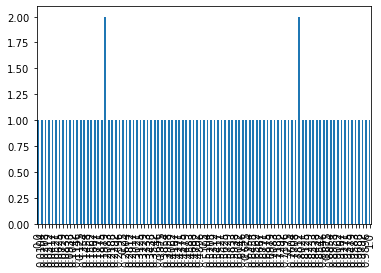

In [14]:
#lista = data.where(data.numGroups == 25).rdd.map(lambda x: x["winPlacePerc"]).collect()
lista = data.where(data.matchId == '6dc8ff871e21e6').rdd.map(lambda x: x["winPlacePerc"]).collect()

tmp = pd.DataFrame()

lista.sort()

tmp["0"] = lista

tmp["0"].value_counts().sort_index().plot(kind="bar")

In [15]:
for i, el in enumerate(lista[0:-1]):
    print(lista[i]-lista[i+1])
    
    

-0.0104
-0.0104
-0.0104
-0.010500000000000002
-0.0104
-0.0104
-0.010400000000000006
-0.010399999999999993
-0.010499999999999995
-0.010400000000000006
-0.010399999999999993
-0.010400000000000006
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.010499999999999982
-0.01040000000000002
-0.010399999999999993
-0.010399999999999993
0.0
-0.01040000000000002
-0.010499999999999982
-0.010399999999999993
-0.01040000000000002
-0.010399999999999993
-0.01040000000000002
-0.020799999999999985
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.01050000000000001
-0.010399999999999965
-0.01040000000000002
-0.01040000000000002
-0.010399999999999965
-0.01050000000000001
-0.01040000000000002
-0.010399999999999965
-0.01040000000000002
-0.010399999999999965
-0.010400000000000076
-0.0103

In [16]:
len(lista)

97

In [17]:
sqlCtx.sql("""SELECT matchtype, matchid, numGroups from pubg""").show(5)

+---------+--------------+---------+
|matchtype|       matchid|numGroups|
+---------+--------------+---------+
|        4|a10357fd1a4a91|       26|
|        4|aeb375fc57110c|       25|
|        2|110163d8bb94ae|       47|
|        4|f1f1f4ef412d7e|       30|
|        1|6dc8ff871e21e6|       95|
+---------+--------------+---------+
only showing top 5 rows



In [18]:
sqlCtx.sql("""SELECT *
                    from pubg 
                    where matchid = '6dc8ff871e21e6' 
                    order by winPlacePerc""").show(100)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+------------------+-------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchtype|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|          distance|isFirstPerson|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------

In [19]:
# Seleziono i duplicati, usabile solo per match da 1 persona
#sqlCtx.sql("""SELECT p1.matchtype, p1.id, p1.groupid, p1.matchid, p1.winPlacePerc, p1.kills
sqlCtx.sql("""SELECT p1.*
                    from pubg p1, pubg p2
                    where p1.matchid = '6dc8ff871e21e6' 
                        and p1.groupid = p2.groupid
                        and p1.id <> p2.id
                    order by winPlacePerc""").show(100)

+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+---------------+---------+------------+--------+-------------+
|            Id|       groupId|       matchId|assists|boosts|damageDealt|DBNOs|headshotKills|heals|killPlace|killPoints|kills|killStreaks|longestKill|matchDuration|matchtype|maxPlace|numGroups|rankPoints|revives|rideDistance|roadKills|swimDistance|teamKills|vehicleDestroys|walkDistance|weaponsAcquired|winPoints|winPlacePerc|distance|isFirstPerson|
+--------------+--------------+--------------+-------+------+-----------+-----+-------------+-----+---------+----------+-----+-----------+-----------+-------------+---------+--------+---------+----------+-------+------------+---------+------------+---------+---------------+------------+-------------

controllare se si può estrarre dagli 0 i giocatori disconnessi da quelli arrivati ultimi.

Cri: forse conviene prima ricavare i giocatori effettivi nel match (ci dovrebbe essere una variabile simile, che indica il numero di squadre)

Cri - osservazioni sul matchid 6dc8ff871e21e6
Questo match è composto da squadre di una persona.
Se osserviamo il plot (score X #persone) vediamo come ci sono alcuni punteggi assegnati a due persone, il che è possibile solo in caso di pareggio. Nello specifico ci sono 4 persone con lo stesso punteggio (=> 2 non dovrebbero esistere)
La lista di giocatori di tale match risulta essere compsta da 97 elementi, tuttavia, l'attributo numGroups ha valore 95 (che torna con i 2 valori anomali).

I due utenti duplicati hanno come id rispettivamente f921a757de248b e cf806bed1e2faa, tuttavia hanno lo stesso groupid. potrebbe essere causato da una perdita di connessione (rientra in partita dopo un crash)?

Alcuni attributi di un player tra quei due di prima risultano a 0 (distance, weaponsAcquired, damageDealt). 
- Potrebbe essere utile unificare i record? UNICA STRADA POSSIBILE
- Conviene eliminare uno dei due duplicati (ad esempio quello con distance==0)? NON FATTIBILE --> non è sempre vero (vedi groupid 8f7560b8e2a612)

Altre ipotesi:
- numGroups indica il numero di gruppi (distinct groupid) nel match
- maxPlace indica il numero di giocatori (distinct playerid) nel match
- La classifica contiene due giocatori con lo stesso punteggio --> sono quelli crashati e riconnessi che hanno id diverso, ma stesso gruppo. 
- Guardando le distanze tra un winplaceperc e il suo successore otteniamo la maggior parte delle volte un valore costante (.0104...), ma non sempre (alcune volte è il doppio: .0208). Penso quindi che i percentili generati siano nello stesso numero di maxPlace. Per tenere di conto del problema delle disconnessioni dovremmo quindi trasformare la percentuale nella posizione effettiva della classifica e ricalcolare i percentili calcolandoli sull'attributo maxPlace


Date queste osservazioni vedo sempre più necessario il fatto di trattare i dati aggregandoli per gruppi così da poter fare un unico modello e, contemporanemente, risolvere il problema delle riconnessioni (anche perchè nel caso del giocatore singolo sei in grado di capire a che giocatore associare i dati aggregati, nel caso di squadra da più persone chi sarà quello che si è disconnesso/crashato?)

Oss: con somma dei risultati i player risultanti avrebbero alcuni attributi con domanio diverso e dipendente dal tipo di match, forse è meglio fare la media

Suggerimenti per l'aggregazione.
Invariati:
- Id: eliminato
- groupId: nuova chiave
- matchId (dipendende funzionalmente dal gruppo)
- matchDuration
- winPlacePerc
- isFirstPerson
- matchtype
- maxPlace
- numGroups

somma o int(media):
- assists: nel caso di solo possono essere anche != da 0, quindi possiamo fare sei la somma che int(media)
- boosts
- heals
- kills
- headshotKills
- killStreaks
- roadKills
- longestKill
- vehicleDestroys (forse anche top, almeno si savano quei pochi che hanno distrutto un veicolo)
- weaponsAcquired

somma o media:
- damageDealt
- distance
- rideDistance
- swimDistance
- walkDistance

migliore?
- killPlace: viene calcolato per ogni giocatore anche in caso di gruppi e riconnessioni.
- rankPoints: sono diversi sempre, anche in caso di gruppi e riconnessioni

#### LA QUERY È FINO A QUI

altri
- DBNOs: questo attributo è sempre uguale a 0 nei solo players. Cosa volgiamo fare? aggregare vorrebbe dire avere domini diversi a seconfa della condizione matchtype=solo, mettere tutto a 0/eliminare l'attributo vorrebbe dire perdere dei dati
- revives
- teamKills

strani:
- killPoints: nei 2 match che ho preso i valori sono sempre 0
- winPoints: anche questi sono sempre a 0 nei due match analizzati

In [20]:
res = sqlCtx.sql("""SELECT 
                        groupId, matchId, matchDuration, winPlacePerc, isFirstPerson, matchtype, maxPlace, numGroups,
                        
                        INT(AVG(assists)) AS assist_AVG, 
                            SUM(assists) AS assist_SUM, 
                            IF(COUNT(*) > matchtype, INT(SUM(assists)/matchtype), INT(SUM(assists)/COUNT(*))) as assist_AVG2,
                            
                        INT(AVG(heals)) AS heals_AVG, 
                            SUM(heals) AS heals_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(heals)/matchtype, SUM(heals)/COUNT(*))) as heals_AVG2,
                            
                        INT(AVG(kills)) AS kills_AVG, 
                            SUM(kills) AS kills_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(kills)/matchtype, SUM(kills)/COUNT(*))) as kills_AVG2,
                            
                        INT(AVG(headshotKills)) AS headshotKills_AVG, 
                            SUM(headshotKills) AS headshotKills_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(headshotKills)/matchtype, SUM(headshotKills)/COUNT(*))) as headshotKills_AVG2,
                            
                        INT(AVG(killStreaks)) AS killStreaks_AVG, 
                            SUM(killStreaks) AS killStreaks_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(killStreaks)/matchtype, SUM(killStreaks)/COUNT(*))) as killStreaks_AVG2,
                            
                        INT(AVG(roadKills)) AS roadKills_AVG, 
                            SUM(roadKills) AS roadKills_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(roadKills)/matchtype, SUM(roadKills)/COUNT(*))) as roadKills_AVG2,
                            
                        INT(AVG(longestKill)) AS longestKill_AVG, 
                            SUM(longestKill) AS longestKill_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(longestKill)/matchtype, SUM(longestKill)/COUNT(*))) as longestKill_AVG2,
                            
                        INT(AVG(vehicleDestroys)) AS vehicleDestroys_AVG, 
                            SUM(vehicleDestroys) AS vehicleDestroys_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(vehicleDestroys)/matchtype, SUM(vehicleDestroys)/COUNT(*))) as vehicleDestroys_AVG2,
                            
                        INT(AVG(weaponsAcquired)) AS weaponsAcquired_AVG, 
                            SUM(weaponsAcquired) AS weaponsAcquired_SUM, 
                            INT(IF(COUNT(*) > matchtype, SUM(weaponsAcquired)/matchtype, SUM(weaponsAcquired)/COUNT(*))) as weaponsAcquired_AVG2,
                            
                        
                        AVG(damageDealt) AS damageDealt_AVG, 
                            SUM(damageDealt) AS damageDealt_SUM, 
                            IF(COUNT(*) > matchtype, SUM(damageDealt)/matchtype, SUM(damageDealt)/COUNT(*)) as damageDealt_AVG2,
                        
                        AVG(distance) AS distance_AVG, 
                            SUM(distance) AS distance_SUM, 
                            IF(COUNT(*) > matchtype, SUM(distance)/matchtype, SUM(distance)/COUNT(*)) as distance_AVG2,
                        
                        AVG(rideDistance) AS rideDistance_AVG, 
                            SUM(rideDistance) AS rideDistance_SUM, 
                            IF(COUNT(*) > matchtype, SUM(rideDistance)/matchtype, SUM(rideDistance)/COUNT(*)) as rideDistance_AVG2,
                        
                        AVG(swimDistance) AS swimDistance_AVG, 
                            SUM(swimDistance) AS swimDistance_SUM, 
                            IF(COUNT(*) > matchtype, SUM(swimDistance)/matchtype, SUM(swimDistance)/COUNT(*)) as swimDistance_AVG2,
                        
                        INT(AVG(walkDistance)) AS walkDistance_AVG, 
                            SUM(walkDistance) AS walkDistance_SUM, 
                            IF(COUNT(*) > matchtype, SUM(walkDistance)/matchtype, SUM(walkDistance)/COUNT(*)) as walkDistance_AVG2,
                         
                         MAX(killPlace) AS killPlace,
                         MAX(rankPoints) AS rankPoints
                         
                         
                    from pubg 
                    group by groupId, matchId, matchDuration, winPlacePerc, isFirstPerson, matchtype, maxPlace, numGroups
                    order by winPlacePerc""")

res.show(10)

+--------------+--------------+-------------+------------+-------------+---------+--------+---------+----------+----------+-----------+---------+---------+----------+---------+---------+----------+-----------------+-----------------+------------------+---------------+---------------+----------------+-------------+-------------+--------------+---------------+---------------+----------------+-------------------+-------------------+--------------------+-------------------+-------------------+--------------------+------------------+---------------+----------------+------------------+------------------+------------------+----------------+----------------+-----------------+----------------+----------------+-----------------+----------------+------------------+------------------+---------+----------+
|       groupId|       matchId|matchDuration|winPlacePerc|isFirstPerson|matchtype|maxPlace|numGroups|assist_AVG|assist_SUM|assist_AVG2|heals_AVG|heals_SUM|heals_AVG2|kills_AVG|kills_SUM|kills_AVG

# Data understanding

data.summary().toPandas()

In [3]:
# Find Count of Null, None, NaN of All DataFrame Columns
from pyspark.sql.functions import col, isnan, when, count

data.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in data.columns]).toPandas()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,distance
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


In [4]:
from pyspark.sql.functions import col

data = data.dropna()

## matchType
string identifying the game mode that the data comes from. The standard modes are “solo”, “duo”, “squad”, “solo-fpp”, “duo-fpp”, and “squad-fpp”; other modes are from events or custom matches.

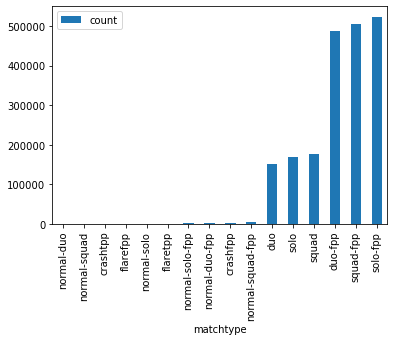

In [5]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [6]:
#tmp.filter(col('count') > 10000)[['matchType']]
toKeep = tmp.rdd.filter(lambda x: x[1] > 10000).map(lambda x: x["matchtype"]).collect()

In [7]:
data = data.filter(data.matchType.isin(toKeep))
data.createOrReplaceTempView("pubg")

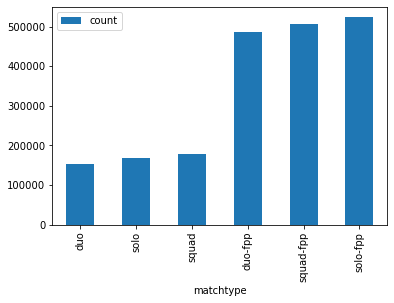

In [8]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

Creazione di una nuova colonna "isFistPerson" per indicare se il match è in modalità prima persona o meno

In [9]:
data = data.withColumn("isFirstPerson", when(col("matchtype").contains("fpp"), True).otherwise(False))

Si raggruppano i tipi di match in 3 categorie: solo, duo e squad

In [10]:
data = data.withColumn("matchtype", when(col("matchtype").contains("duo"), 2)
                           .when(col("matchtype").contains("solo"), 1)
                           .otherwise(4))

data.createOrReplaceTempView("pubg")

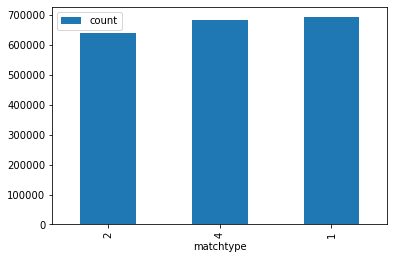

In [11]:
tmp = sqlCtx.sql("""SELECT matchtype, count(distinct groupId) as count FROM pubg GROUP BY matchtype ORDER BY count(distinct groupId)""")
tmp.toPandas().set_index("matchtype").plot(kind="bar")

In [12]:
#sample del dataframe spark per plotting
seed = 42
df_pandas = data.sample(False, 0.2, seed).toPandas()

# Alternativa
#df = data[['killPlace', 'winPlacePerc', 'matchtype']].sample(False, 0.5, seed).toPandas()
#df = data[['killPlace', 'winPlacePerc', 'matchtype']].toPandas()
df_pandas.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchtype', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc', 'distance',
       'isFirstPerson'],
      dtype='object')

## Identificatori: Id, groupId, matchId

Id: unique identifier of a single player, which can partecipate or not in a team.

groupId: ID to identify a group within a match. If the same group of players plays in different matches, they will have a different groupId each time.

matchID: ID to identify match.

In [13]:
F'Record totali: {data.count()}'

'Record totali: 4411698'

In [14]:
sqlCtx.sql("""SELECT count(distinct Id) FROM pubg""").show()
sqlCtx.sql("""SELECT count(distinct groupId) FROM pubg""").show()
sqlCtx.sql("""SELECT count(distinct matchId) FROM pubg""").show()

+------------------+
|count(DISTINCT Id)|
+------------------+
|           4411698|
+------------------+

+-----------------------+
|count(DISTINCT groupId)|
+-----------------------+
|                2014090|
+-----------------------+

+-----------------------+
|count(DISTINCT matchId)|
+-----------------------+
|                  47185|
+-----------------------+



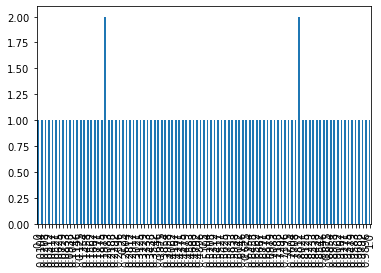

In [15]:
lista = data.where(data.matchId == '6dc8ff871e21e6').rdd.map(lambda x: x["winPlacePerc"]).collect()
tmp = pd.DataFrame()
lista.sort()
tmp["0"] = lista
tmp["0"].value_counts().sort_index().plot(kind="bar")

## assist

the assists means that i don't kill enemy but help kill enemy. So when you look at the variable, there is also a kill. In other words, if I kill the enemy? kill +1. but if I did not kill the enemy but helped kill the enemy?assists + 1

In [16]:
data.select('assists').summary().show()

+-------+-------------------+
|summary|            assists|
+-------+-------------------+
|  count|            4411698|
|   mean|0.22876361890591787|
| stddev| 0.5704108734878232|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  0|
|    max|                 12|
+-------+-------------------+



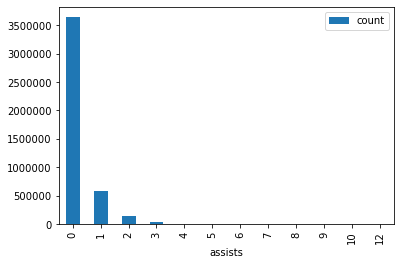

In [17]:
data.groupBy('assists').count().orderBy(col('count').desc()).toPandas().set_index('assists').plot(kind='bar')

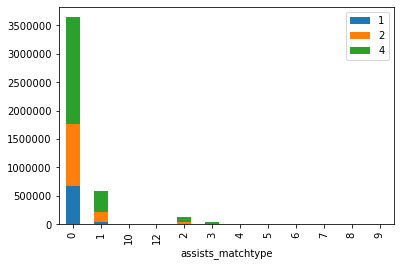

In [18]:
cross_tab = data.crosstab('assists', 'matchtype').toPandas().sort_values(by=["assists_matchtype"]).set_index('assists_matchtype')
cross_tab.plot.bar(stacked=True)

> cri: visto che i colori si sovrappongono conviene forse fare questo tipo di grafico già escludendo i gametype con pochi record (quindi usando il dataset con i soli tipi solo, duo o squad e valutare se discriminare fpp o tpp)

> cri2: ho riordinato i risultati per assist_matchtype, controllate che non abbia fatto casino con crosstab e soprattutto con l'ordine in cui avete eseguito il codice (per come l'ho trovato avevate saltato il codice che cambiava matchtype da stringa a numerico)

## boosts

number of boost items used. Both 'boosts' and 'heals' variables are items that restore health. But the boosts immediately show the effect, and the heals show the effect slowly.

In [19]:
data.select('boosts').summary().show()

+-------+------------------+
|summary|            boosts|
+-------+------------------+
|  count|           4411698|
|   mean|1.1049192397122378|
| stddev|1.7146506619500843|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 2|
|    max|                33|
+-------+------------------+



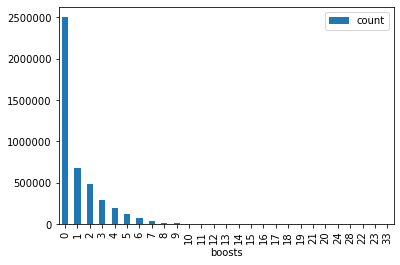

In [20]:
data.groupBy('boosts').count().orderBy(col('count').desc()).toPandas().set_index('boosts').plot(kind='bar')

## damageDealt

total damage dealt. Note: Self inflicted damage is subtracted. If it is not headshot, it does not die in one shot. So restores health by using boosts or heals. 'damageDealt' means how many bullets have ever been hit.

In [21]:
data.select('damageDealt').summary().show()

+-------+------------------+
|summary|       damageDealt|
+-------+------------------+
|  count|           4411698|
|   mean|129.26890968896862|
| stddev|165.55830220522043|
|    min|               0.0|
|    25%|               0.0|
|    50%|             83.85|
|    75%|             185.1|
|    max|            3796.0|
+-------+------------------+



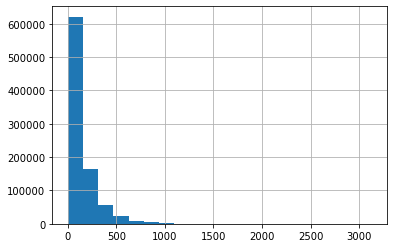

In [22]:
df_pandas.damageDealt.hist(bins=20)

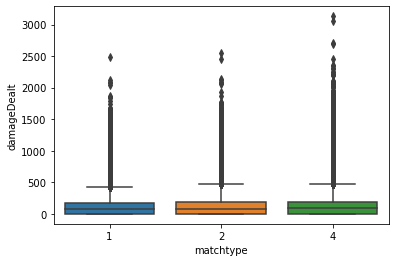

In [23]:
sns.boxplot(x="matchtype", y="damageDealt", data=df_pandas)

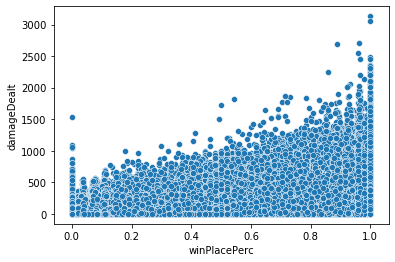

In [24]:
sns.scatterplot(x="winPlacePerc", y="damageDealt", data=df_pandas)

## DBNOs
number of enemy players knocked. DBNOs variable means Number of enemy players knocked. Knocked is not dead, but can not act. so if you are knocked, your colleagues can save you (revives variable) but if you died? you don't save... :(

In [25]:
data.select('DBNOs').summary().show()

+-------+------------------+
|summary|             DBNOs|
+-------+------------------+
|  count|           4411698|
|   mean|0.6541451840085155|
| stddev|1.1241384530222183|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                32|
+-------+------------------+



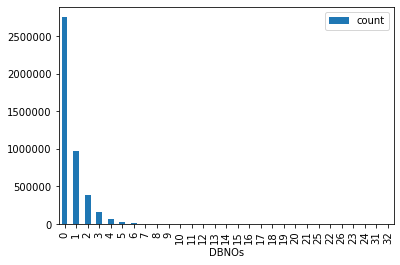

In [26]:
data.groupBy('DBNOs').count().orderBy(col('count').desc()).toPandas().set_index('DBNOs').plot(kind='bar')

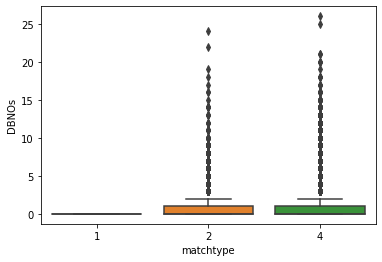

In [27]:
sns.boxplot(x="matchtype", y="DBNOs", data=df_pandas)

Si osserva che DBNOs è sempre 0 per i match di tipo 'solo'

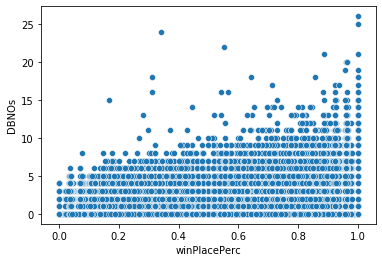

In [28]:
sns.scatterplot(x="winPlacePerc", y="DBNOs", data=df_pandas)

> cri: Forse questi con molti dati conviene farli su un subsample 

## headshotKills
number of enemy players head-shotted's. It means that a bullet hit his head and he died right away. It's important that he died right away.

In [29]:
data.select('headshotKills').summary().show()

+-------+-------------------+
|summary|      headshotKills|
+-------+-------------------+
|  count|            4411698|
|   mean|0.22373176949102136|
| stddev| 0.5859880788905978|
|    min|                  0|
|    25%|                  0|
|    50%|                  0|
|    75%|                  0|
|    max|                 26|
+-------+-------------------+



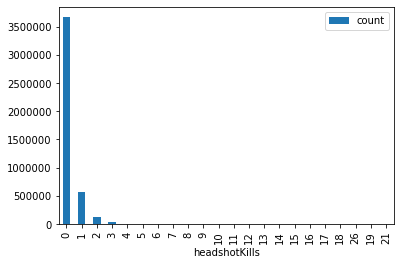

In [30]:
data.groupBy('headshotKills').count().orderBy(col('count').desc()).toPandas().set_index('headshotKills').plot(kind='bar')

## heals
 number of healing items used. See difference with 'boots'.

In [31]:
data.select('heals').summary().show()

+-------+------------------+
|summary|             heals|
+-------+------------------+
|  count|           4411698|
|   mean|1.3620658077683467|
| stddev| 2.669458631778128|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 2|
|    max|                80|
+-------+------------------+



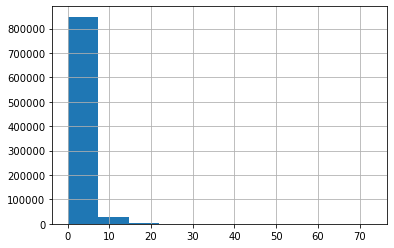

In [32]:
df_pandas.heals.hist()

In [33]:
data.groupBy('matchtype').avg('heals').toPandas()

,matchtype,avg(heals)
0,1,1.010299
1,4,1.485113
2,2,1.331256


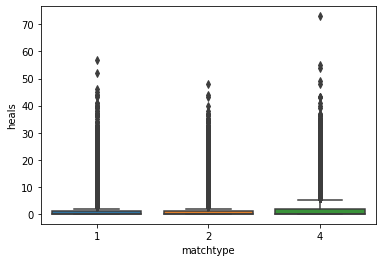

In [34]:
sns.boxplot(x="matchtype", y="heals", data=df_pandas)

## killPlace
 ranking in match of number of enemy players killed.

In [35]:
data.select('killPlace').summary().show()

+-------+------------------+
|summary|         killPlace|
+-------+------------------+
|  count|           4411698|
|   mean|47.728825499841555|
| stddev|27.460104599625414|
|    min|                 1|
|    25%|                24|
|    50%|                48|
|    75%|                71|
|    max|               100|
+-------+------------------+



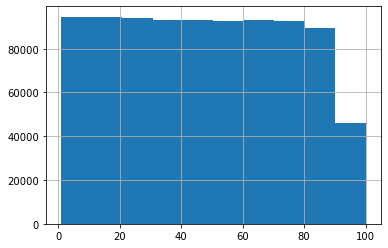

In [36]:
df_pandas.killPlace.hist(bins=10)

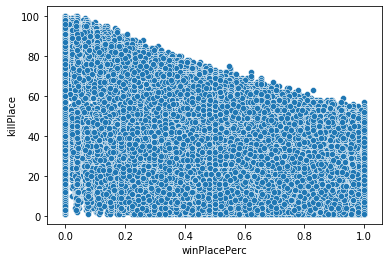

In [37]:
sns.scatterplot(x="winPlacePerc", y="killPlace", data=df_pandas)

## killPoints
kills-based external ranking of player. (Think of this as an Elo ranking where only kills matter.) If there is a value other than -1 in rankPoints, then any 0 in killPoints should be treated as a “None”.

In [38]:
data.select('killPoints').summary().show()

+-------+-----------------+
|summary|       killPoints|
+-------+-----------------+
|  count|          4411698|
|   mean|506.1995855110663|
| stddev| 628.409489512835|
|    min|                0|
|    25%|                0|
|    50%|                0|
|    75%|             1175|
|    max|             2170|
+-------+-----------------+



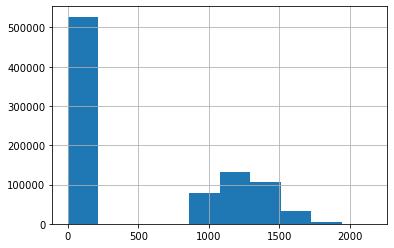

In [39]:
df_pandas.killPoints.hist()

## kills
number of enemy players killed.
composed by 'headshotKills', 'roadKills', not 'teamKills'

In [40]:
data.select('kills').summary().show()
df_pandas[['kills', 'headshotKills', 'roadKills']].head(5)

+-------+------------------+
|summary|             kills|
+-------+------------------+
|  count|           4411698|
|   mean|0.9116072768353591|
| stddev|1.5010820312237814|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                33|
+-------+------------------+



,kills,headshotKills,roadKills
0,0,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,1,0,0


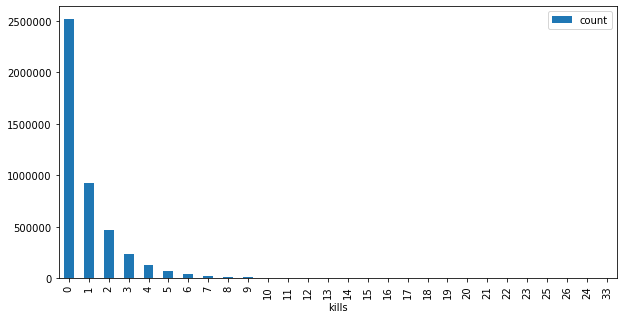

In [41]:
#df_pandas.kills.hist()
data.groupBy('kills').count().orderBy(col('count').desc()).toPandas().set_index('kills').plot(kind='bar', figsize=(10,5))

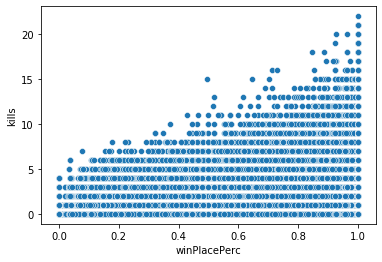

In [42]:
sns.scatterplot(x="winPlacePerc", y="kills", data=df_pandas)

## killStreaks
max number of enemy players killed in a short amount of time.

In [43]:
data.select('kills').summary().show()

+-------+------------------+
|summary|             kills|
+-------+------------------+
|  count|           4411698|
|   mean|0.9116072768353591|
| stddev|1.5010820312237814|
|    min|                 0|
|    25%|                 0|
|    50%|                 0|
|    75%|                 1|
|    max|                33|
+-------+------------------+



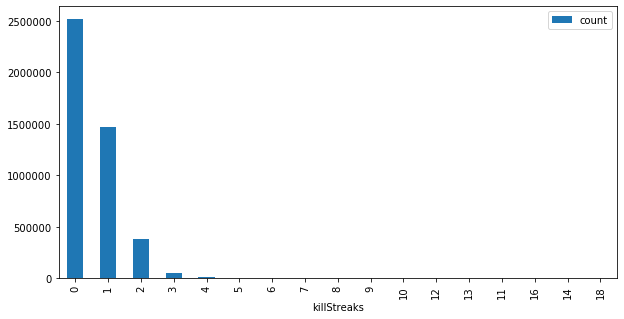

In [44]:
#df_pandas.kills.hist()
data.groupBy('killStreaks').count().orderBy(col('count').desc()).toPandas().set_index('killStreaks').plot(kind='bar', figsize=(10,5))

## longestKill
longest distance between player and player killed at time of death. This may be misleading, as downing a player and driving away may lead to a large longestKill stat.

In [45]:
data.select('longestKill').summary().show()

+-------+------------------+
|summary|       longestKill|
+-------+------------------+
|  count|           4411698|
|   mean|22.837279579268337|
| stddev| 50.65590048388228|
|    min|               0.0|
|    25%|               0.0|
|    50%|               0.0|
|    75%|             21.12|
|    max|            1003.0|
+-------+------------------+



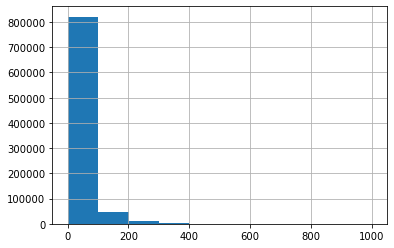

In [46]:
df_pandas.longestKill.hist()

## matchDuration
duration of whole single/teammate match in seconds.

In [47]:
data.where(col('matchid') == 'aeb375fc57110c').toPandas()[['groupId', 'matchDuration']].head(10)

,groupId,matchDuration
0,684d5656442f9e,1777
1,557ca8543fb0dd,1777
2,b9e8b77c01059b,1777
3,4c526bf789bcf4,1777
4,766390c7622843,1777
5,44961cf90f1aba,1777
6,766390c7622843,1777
7,b88c63770f6f54,1777
8,4c526bf789bcf4,1777
9,645894055adb04,1777


In [48]:
data.select('matchDuration').summary().show()

+-------+------------------+
|summary|     matchDuration|
+-------+------------------+
|  count|           4411698|
|   mean|1580.7029753623208|
| stddev| 254.4928844346351|
|    min|               728|
|    25%|              1367|
|    50%|              1438|
|    75%|              1850|
|    max|              2237|
+-------+------------------+



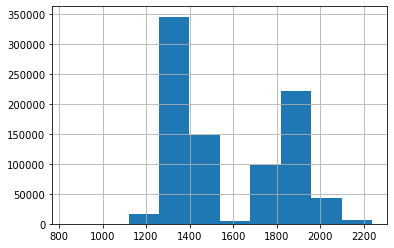

In [49]:
df_pandas.matchDuration.hist()

In [50]:
#data.groupBy('matchType').avg('matchDuration').toPandas()

## maxPlace
worst placement we have data for in the match. This may not match with numGroups, as sometimes the data skips over placements.

In [51]:
data.select('maxPlace').summary().show()

+-------+------------------+
|summary|          maxPlace|
+-------+------------------+
|  count|           4411698|
|   mean|44.678357176760514|
| stddev| 23.80913546335595|
|    min|                 2|
|    25%|                28|
|    50%|                30|
|    75%|                49|
|    max|               100|
+-------+------------------+



In [52]:
data.groupBy('matchtype').avg('maxPlace').toPandas()

,matchtype,avg(maxPlace)
0,1,94.112814
1,4,28.099487
2,2,47.711240


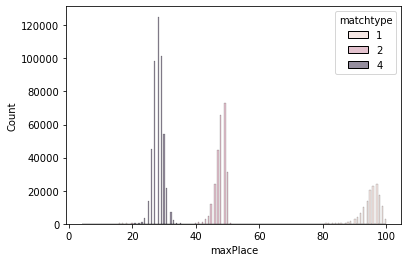

In [53]:
sns.histplot(data=df_pandas, x='maxPlace', hue='matchtype')

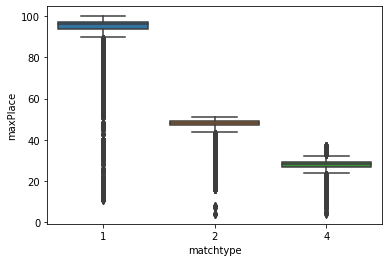

In [54]:
sns.boxplot(x="matchtype", y="maxPlace", data=df_pandas)

## numGroups
number of groups we have data for in the match

In [55]:
data.select('numGroups').summary().show()

+-------+------------------+
|summary|         numGroups|
+-------+------------------+
|  count|           4411698|
|   mean| 43.17773383400224|
| stddev|23.273124609259003|
|    min|                 1|
|    25%|                27|
|    50%|                30|
|    75%|                47|
|    max|               100|
+-------+------------------+



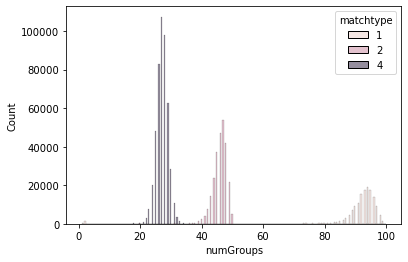

In [56]:
sns.histplot(data=df_pandas, x='numGroups', hue='matchtype')

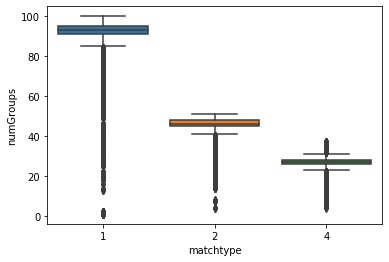

In [57]:
sns.boxplot(x="matchtype", y="numGroups", data=df_pandas)

## rankPoints
Elo-like ranking of player. This ranking is inconsistent and is being deprecated in the API’s next version, so use with caution. Value of -1 takes place of “None”.

In [58]:
data.select('rankPoints').summary().show()

+-------+-----------------+
|summary|       rankPoints|
+-------+-----------------+
|  count|          4411698|
|   mean|891.4181822962496|
| stddev|736.7605919566126|
|    min|               -1|
|    25%|               -1|
|    50%|             1443|
|    75%|             1500|
|    max|             5910|
+-------+-----------------+



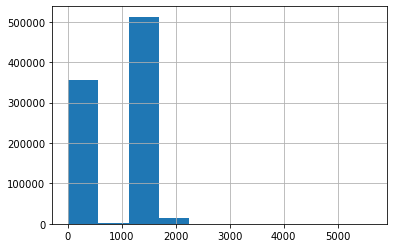

In [59]:
df_pandas.rankPoints.hist()

In [36]:
data.columns

['Id',
 'groupId',
 'matchId',
 'assists',
 'boosts',
 'damageDealt',
 'DBNOs',
 'headshotKills',
 'heals',
 'killPlace',
 'killPoints',
 'kills',
 'killStreaks',
 'longestKill',
 'matchDuration',
 'matchtype',
 'maxPlace',
 'numGroups',
 'rankPoints',
 'revives',
 'rideDistance',
 'roadKills',
 'swimDistance',
 'teamKills',
 'vehicleDestroys',
 'walkDistance',
 'weaponsAcquired',
 'winPoints',
 'winPlacePerc',
 'distance',
 'isFirstPerson']

In [37]:
categorical_columns = [ 'matchType', 'Id', 'groupId', 'matchId']
numerical_columns =[ 'assists',
                     'boosts',
                     'damageDealt',
                     'DBNOs',
                     'headshotKills',
                     'heals',
                     'killPlace',
                     'killPoints',
                     'kills',
                     'killStreaks',
                     'longestKill',
                     'matchDuration',
                     'maxPlace',
                     'numGroups',
                     'rankPoints',
                     'revives',
                     'rideDistance',
                     'roadKills',
                     'swimDistance',
                     'teamKills',
                     'vehicleDestroys',
                     'walkDistance',
                     'weaponsAcquired',
                     'winPoints',
                     'winPlacePerc',
                     'distance']

# Correlazioni

In [38]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler

In [39]:
# convert to vector column first
vector_col = "corr_features"
assembler = VectorAssembler(inputCols=numerical_columns, outputCol=vector_col)
df_vector = assembler.transform(data).select(vector_col)

# get correlation matrix
pearsonCorr = Correlation.corr(df_vector, vector_col, 'pearson').collect()[0][0]
#spearmanCorr = Correlation.corr(df_vector, vector_col, 'spearman').collect()[0][0]  spearman ci mette tanto

In [65]:
import seaborn as sns
cm = sns.light_palette("green", as_cmap=True)

pd.DataFrame(pearsonCorr.toArray(), numerical_columns, numerical_columns)\
    .style.applymap(lambda x: 'background-color:rgb({}, 255, {});'.format(255-x*155, 255-x*155) if x > 0 else 'background-color:rgb(255, {}, {});'.format(255+x*255, 255+x*255))

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,distance
assists,1.000000,0.320749,0.381016,0.293719,0.178718,0.229092,-0.290405,0.040950,0.289653,0.235733,0.259647,-0.005065,-0.141422,-0.140108,-0.015726,0.200387,0.114171,0.012137,0.025339,0.002428,0.058771,0.303187,0.200232,0.023629,0.305667,0.243547
boosts,0.320749,1.000000,0.542588,0.367556,0.347165,0.537856,-0.556801,0.008470,0.526504,0.409361,0.426893,0.068290,-0.012870,-0.012221,0.023556,0.254074,0.328304,0.037011,0.108672,0.013844,0.086519,0.641220,0.437042,-0.007868,0.636463,0.575174
damageDealt,0.381016,0.542588,1.000000,0.751865,0.603859,0.346487,-0.690223,0.052097,0.883154,0.708764,0.571355,0.008126,-0.029766,-0.028839,-0.000083,0.263056,0.146487,0.056176,0.038988,0.011980,0.082992,0.415061,0.313862,0.017024,0.450645,0.326772
DBNOs,0.293719,0.367556,0.751865,1.000000,0.477154,0.267661,-0.563748,0.043676,0.726880,0.655835,0.458233,-0.011996,-0.269760,-0.267906,-0.002809,0.300143,0.104814,0.037038,0.018033,0.071254,0.060661,0.291889,0.212729,0.010672,0.284162,0.230897
headshotKills,0.178718,0.347165,0.603859,0.477154,1.000000,0.201067,-0.477337,0.025021,0.666665,0.513568,0.451981,-0.006956,0.017484,0.017929,0.006113,0.153329,0.081121,0.017846,0.029792,0.007054,0.041441,0.261289,0.189479,0.004342,0.282640,0.198203
heals,0.229092,0.537856,0.346487,0.267661,0.201067,1.000000,-0.386412,-0.002508,0.316061,0.270500,0.263564,0.110821,-0.061706,-0.061186,0.019856,0.237253,0.298133,0.027361,0.080509,0.035369,0.063064,0.432806,0.317732,-0.011610,0.430058,0.440607
killPlace,-0.290405,-0.556801,-0.690223,-0.563748,-0.477337,-0.386412,1.000000,-0.023708,-0.749422,-0.812671,-0.542635,-0.009543,0.011119,0.013135,-0.015537,-0.270765,-0.235068,-0.054830,-0.090309,-0.037453,-0.072358,-0.592766,-0.506912,-0.001816,-0.720910,-0.484828
killPoints,0.040950,0.008470,0.052097,0.043676,0.025021,-0.002508,-0.023708,1.000000,0.038448,0.037749,0.014193,-0.105284,-0.045941,-0.043541,-0.975656,0.011994,-0.028107,0.001128,-0.004823,-0.039433,-0.008610,0.004068,-0.004237,0.983563,0.013001,-0.017050
kills,0.289653,0.526504,0.883154,0.726880,0.666665,0.316061,-0.749422,0.038448,1.000000,0.814002,0.615467,-0.013535,0.007434,0.008614,0.009578,0.261437,0.121336,0.064321,0.041831,0.013990,0.082610,0.394503,0.292890,0.006242,0.431588,0.298429
killStreaks,0.235733,0.409361,0.708764,0.655835,0.513568,0.270500,-0.812671,0.037749,0.814002,1.000000,0.515613,-0.027490,-0.033327,-0.031920,0.003759,0.243088,0.099575,0.064270,0.035321,0.026690,0.063284,0.331427,0.269843,0.008356,0.377973,0.249104


> Cri: ha senso fare la correlazione tra attributi che sono determinati dal match vs quelli che sono determinati dal giocatore? (io penso di si, ma forse è meglio che ci riflettiate anche voi)